In [1]:
import torch
import pytorch_lightning as pl

import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

pl.seed_everything(93)
torch.set_float32_matmul_precision('medium')

# Model parameters
N_LAYERS = 5
HIDDEN_DIM = 50
EMBEDDING_DIM = 5
N_HEADS = 4
DROPOUT = 0.25

# Dataset parameters
RADIUS = 0.3
SEQ_LEN = 10
CELL_SIZE = 1
GRID_AND_RANDOM_SAMPLING = False
N_NODES = 750

# Training parameters
BATCH_SIZE = 32
NUM_WORKERS = 10
EPOCHS = 5
WEIGHT_DECAY = 0
LEARNING_RATE = 1e-3


TRAIN = True
CKPT_PTH = "saved_models/gsi_hparam2/lightning_logs/version_23/checkpoints/epoch=4-step=3770.ckpt"

/home/nwinkler/.conda/envs/pyg/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/nwinkler/.conda/envs/pyg/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Seed set to 93


In [2]:
from data.synthetic import SyntheticDataset, SyntheticDataModule

from models.rabignn import PLModule
import torch_geometric.transforms as T
from utils.transforms import Add2DMask, Apply2DMask
from torch_geometric.loader import DataLoader
import random


hparams = {
    'seq_len': SEQ_LEN,
    'hidden_dim': HIDDEN_DIM,
    'embedding_dim': EMBEDDING_DIM,
    'n_layers': N_LAYERS,
    'n_heads': N_HEADS,
    'learning_rate': LEARNING_RATE,
    'dropout': DROPOUT,
    'weight_decay': WEIGHT_DECAY,
}
    
transform = T.Compose([
            T.Distance(norm=False),
            T.Cartesian(),
            Add2DMask(random.uniform(0.02, 0.15),
                        seq_len=SEQ_LEN),
            Apply2DMask(),
        ])

model = PLModule(hparams=hparams)
dataset = SyntheticDataset(root="data/30x25/", type="valid", radius=RADIUS, seq_len=SEQ_LEN, n_nodes=N_NODES, transform=transform)
datamodule = SyntheticDataModule(seq_len=SEQ_LEN, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, n_nodes=N_NODES, transform=transform)

# Example prediction:
loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)
data = next(iter(loader))
out = model(data)
out.shape

torch.Size([24000, 10])

In [3]:
LOG_DIR = "models/logs"

tb_logger = pl.loggers.TensorBoardLogger(save_dir=LOG_DIR, name="feb", default_hp_metric=True)

trainer = pl.Trainer(
    logger=tb_logger,
    max_epochs=EPOCHS,
    enable_progress_bar=True,
    accelerator="auto" if torch.cuda.is_available() else "cpu",
    default_root_dir=LOG_DIR,
    devices=[3],
    fast_dev_run=False
)

if TRAIN == True:
    trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name     | Type    | Params
-------------------------------------
0 | model    | GNN     | 261 K 
1 | loss_mse | MSELoss | 0     
-------------------------------------
261 K     Trainable params
0         Non-trainable params
261 K     Total params
1.047     Total estimated model params size (MB)


/home/nwinkler/.conda/envs/pyg/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 24000. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 1:   0%|          | 0/495 [00:00<?, ?it/s, v_num=2, train_loss_step=0.128, val_loss=0.105, train_loss_epoch=0.179]          

/home/nwinkler/.conda/envs/pyg/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 18000. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 4: 100%|██████████| 495/495 [02:27<00:00,  3.35it/s, v_num=2, train_loss_step=0.0779, val_loss=0.071, train_loss_epoch=0.0765] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 495/495 [02:27<00:00,  3.35it/s, v_num=2, train_loss_step=0.0779, val_loss=0.071, train_loss_epoch=0.0765]


In [4]:
#ckpt_path = "models/logs/feb/version_0/checkpoints/epoch=4-step=2475.ckpt"

#model = PLModule.load_from_checkpoint(ckpt_path).to('cpu')
model.eval()

PLModule(
  (model): GNN(
    (dropout): Dropout(p=0.25, inplace=False)
    (embedding_layer): Linear(20, 5, bias=True)
    (first_layer): GATv2Conv(15, 50, heads=4)
    (inner_layers): ModuleList(
      (0-2): 3 x GATv2Conv(205, 50, heads=4)
    )
    (last_layer): GATv2Conv(205, 10, heads=1)
  )
  (loss_mse): MSELoss()
)

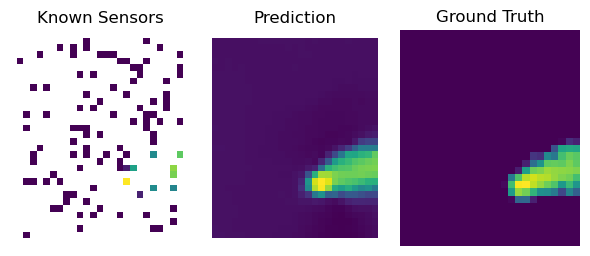

In [7]:
from utils.mapping import plot_data

data = dataset[5000]

with torch.no_grad():
    pred = model(data)

plot_data(data, pred, data.orig_pos, cell_size=1, ground_truth=data.y)